# Differentially Private Alternating Minimization

Copyright 2023 The Google Research Authors.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This colab accompanies the papers
- [Private Alternating Least Squares](https://proceedings.mlr.press/v139/chien21a.html)
- [Multi-Task Differential Privacy Under Distribution Skew](https://arxiv.org/abs/2302.07975)

**Problem formulation**

Let $M$ be a ratings matrix, where rows represent users and columns represent items. Let $U, V$ be the user and item embeddings, respectively. The goal is to approximate $M$ with the low-rank matrix $UV^\top$. The loss function is

$$
L(U, V) = \sum_{(i, j) \in \Omega} \Big[(M_{ij} - \langle u_i, v_j\rangle)^2 + \lambda(\|u_i\|^2 + \|v_j\|^2)\Big] + \alpha_0 \sum_{i, j} \langle u_i, v_j\rangle^2
$$
where
- $\Omega$ is the set of "observed" pairs, i.e. the $(i, j)$ such that user $i$ has rated item $j$,
- $\alpha_0$ (unobserved weight) and $\lambda$ (regularization) are two hyper-parameters.


**Algorithms**

1) Data sanitization

The `Sanitizer` class is used to pre-process the data. All pre-processing operations are differentially private. Pre-processing includes:
1. Center the data.
2. Compute approximate item counts by subsampling each user (uniformly) and adding Gaussian noise.
3. Limit the L2 sensitivity w.r.t. each user's data, either by sampling (as in the [DPALS paper](https://proceedings.mlr.press/v139/chien21a.html)) or by using adaptive budget allocation (as in the [DP Under Skew paper](https://arxiv.org/abs/2302.07975)).

2) Training

DP alternating minimization (DPAM) alternates between:
1. Solving for the user embeddings $u_i$, using (exact) least squares
2. Training the item embedding $v_j$. This is a DP linear regression problem and can be solved using different methods:
  - In the `DPALSModel` class, this is done using sufficient statistics perturbation (SSP).
  - In the `DPAMModel` class, this is done using noisy gradient methods (for example the `DPSparseKerasSGDOptimizer`)



**Benchmarks**

We use two benchmarks based on the [MovieLens](https://grouplens.org/datasets/movielens/) data.

- The MovieLens20M benchmark is a classification task, and follows the protocol of [Liang et al. (2018)](https://dl.acm.org/doi/10.1145/3178876.3186150):
  - The validation and test set each consist of new users, i.e. users not present in the train set.
  - The ratings of each user are split into a "history" and target predictions (corresponding to `validation_tr` and `validation_te`, respectively).
  - The protocol is to use `validation_tr` to compute a user embedding (via a one-step row solve), then use that embedding to compute predictions.
  - For the purpose of computing recall, the "history" is excluded from the set of candidates, so that the model is not penalized for retrieving a positive item from the history.
  - The same applies to the test set, which is split into `test_tr` and `test_te`.
- The MovieLens10M benchmark is a regression task, and follows the protocol of [Lee et al. (2013)](https://dl.acm.org/doi/10.5555/2946645.2946660):
  - The ratings are split into train/validation/test using a 80/10/10 split.

The script `generate_movielens_data.py` (run in the second cell below) downloads and processes the MovieLens data following the protocols defined in the papers above.

# Setup (run all cels in this section)

In [ ]:
%%capture
# Install dp_alternating_minimization (only download sub-tree of the
# google-research repo, because it's too large)
!apt-get install subversion
!svn export https://github.com/google-research/google-research/trunk/dp_alternating_minimization
!pip3 install -r dp_alternating_minimization/requirements.txt

# Install tensorflow_privacy (dev version, for access to latest optimizers)
!pip3 install git+https://github.com/tensorflow/privacy

In [ ]:
# Download and pre-process MovieLens data.
!python movielens/generate_movielens_data.py

In [ ]:
#@title Imports

import tensorflow as tf

import copy
import time
import os
import gc
import numpy as np
import pandas as pd
from IPython import display
from matplotlib import pyplot as plt
import sklearn.manifold
import altair as alt

from dp_alternating_minimization import dpam

SparseMatrix = dpam.SparseMatrix
Sanitizer = dpam.Sanitizer
Dataset = dpam.Dataset
DPALSModel = dpam.DPALSModel
DPALSOptimizer = dpam.DPALSOptimizer
DPALSAccountant = dpam.DPALSAccountant
AMModel = dpam.AMModel
DPAMAccountant = dpam.DPAMAccountant

RMSE_METRICS = [["valid_RMSE", "test_RMSE"],]
RECALL_METRICS = [["valid_R@20", "test_R@20"],]

alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline

In [ ]:
#@title Movielens data

def load_data(basedir):

  def shift_uid(matrix):
    """Shifts the uid so that it starts at 0."""
    min_uid = min(matrix.data.uid)
    if matrix.history is not None:
      min_uid = min(min_uid, min(matrix.history.uid))
    matrix.data.uid = matrix.data.uid - min_uid
    if matrix.history is not None:
      matrix.history.uid = matrix.history.uid - min_uid

  def exists(filename):
    return tf.io.gfile.exists(os.path.join(basedir, filename))

  def read_csv(filename, sort=True):
    print(f'reading {filename}', flush=True)
    df = pd.read_csv(tf.io.gfile.GFile(os.path.join(basedir, filename)))
    if sort:
      df = df.sort_values(['uid', 'sid'])
    return df

  t0 = time.time()
  train_df = read_csv('train.csv')
  train = SparseMatrix(train_df)
  if exists('validation_tr.csv'):
    validation = SparseMatrix(
        read_csv('validation_te.csv'),
        read_csv('validation_tr.csv'))
    shift_uid(validation)
  else:
    # If there is no tr/te split, use training data for projection.
    validation = SparseMatrix(
        read_csv('validation.csv'), train_df)
  if exists('test_tr.csv'):
    test = SparseMatrix(
        read_csv('test_te.csv'),
        read_csv('test_tr.csv'))
    shift_uid(test)
  else:
    # For the test set, use both train and validation for the projection.
    test = SparseMatrix(read_csv('test.csv'), pd.concat([train_df, validation.data]))

  print(f'Creating Dataset', flush=True)
  # metadata
  metadata = read_csv('features.csv', sort=False)
  metadata['genres_ML'] = metadata.apply(lambda x: x['genres'].split('|'), axis = 1)
  num_users = max([max(d.data["uid"]) for d in (train, validation, test)]) + 1
  num_items = max([max(d.data["sid"]) for d in (train, validation, test)]) + 1
  if num_items < max(metadata["sid"]) + 1:
    num_items = max(metadata["sid"]) + 1
  dataset = Dataset(
      num_users, num_items, metadata, train=train, validation=validation,
      test=test)
  print(f"Done in {int(time.time() - t0)}s.")
  return dataset


In [ ]:
#@title Plotting utils
class Visualizer(object):

  def __init__(self, model):
    """Initializes a Visualizer object.

    Args:
      model: an object that provides the following members: model.dataset,
        model.embeddings and model.rmses.
    """
    # Build a users_df and items_df for visualization.
    dataset = model.dataset
    num_users = dataset.test.num_users
    num_items = dataset.num_items
    users_df = pd.DataFrame.from_dict({"uid": range(num_users)})
    users_df["title"] = users_df["uid"]
    
    # Use test users counts (to handle cold-start users), and train item counts.
    users_df["num_ratings"] = dataset.user_counts_test[users_df["uid"]]
    items_df = None
    if dataset.metadata_df is not None:
      items_df = dataset.metadata_df.copy()
      items_df["num_ratings"] = dataset.item_counts_train[items_df["sid"]]
      # For the purpose of visualization, select one genre per movie.
      items_df["genres"] = items_df["genres"].apply(lambda x: np.random.choice(x.split("|")))
    self._users_df = users_df
    self._items_df = items_df
    self._model = model

  def _scatter_plot(self, user, y_vals, y_label, density=False,
                    xlogscale=False):
    if user:
      df = self._users_df
      indices = df["uid"]
    else:
      df = self._items_df
      indices = df["sid"]
    df = pd.DataFrame({
        'title': df['title'],
        'num_ratings': df['num_ratings'],
        y_label: y_vals[indices],
    })
    if xlogscale:
      df['num_ratings'] = np.log(1+df['num_ratings'])
    scatter_chart = (
        alt.Chart(df)
        .mark_point(opacity=0.5, size=5)
        .encode(x=alt.X('num_ratings', title="#ratings"),
                y=alt.Y(y_label, title=y_label),
                tooltip='title'))
    def get_bin_step(key):
      # Force the step to get exactly 30 bins.
      min_val = df[key].min()
      max_val = df[key].max()
      return (max_val - min_val)/30
    density_chart = alt.Chart(df).mark_rect().encode(
          alt.X('num_ratings', bin=alt.Bin(step=get_bin_step("num_ratings"))),
          alt.Y(f'{y_label}', bin=alt.Bin(step=get_bin_step(y_label))),
          alt.Color(f'count({y_label})',
                    scale=alt.Scale(type="log", scheme='yelloworangered')))
    chart = alt.LayerChart()
    if density:
      chart += density_chart
    else:
      chart += scatter_chart
    return chart

  def scatter_user_embedding_norm(self, density=False, xlogscale=False):
    return self._scatter_plot(
        user=True, y_vals=np.linalg.norm(self._model.row_embeddings, axis=1),
        y_label='embedding norm', density=density, xlogscale=xlogscale)

  def scatter_item_embedding_norm(self, density=False, xlogscale=False):
    return self._scatter_plot(
        user=False, y_vals=np.linalg.norm(self._model.col_embeddings, axis=1),
        y_label='embedding norm', density=density, xlogscale=xlogscale)

  def nearest_neighbors(
      self, title_substring, cosine=True, k=6, latex=False,
      latex_cols=None):
    # Search for item ids that match the given substring.
    title_substring = title_substring.lower()
    all_titles = self._items_df['title'].str.lower()
    matches = self._items_df[all_titles.map(lambda x: title_substring in x)]
    titles = matches['title'].values
    if len(titles) == 0:
      raise ValueError("Found no items with title %s" % title_substring)
    if len(titles) > 1:
      print("Note: Found more than one matching item. Other candidates:\n{}"
            .format("\n".join(titles[1:])))
    print(f"Nearest neighbors of: {titles[0]} (sid: {matches['sid'].values[0]})")
    item_id = matches.sid.values[0]
    V = self._model.col_embeddings.numpy()
    if cosine:
      V = V / np.maximum(1e-10, np.linalg.norm(V, axis=1, keepdims=True))
    scores = V[item_id].dot(V.T)
    score_key = 'cosine score' if cosine else 'dot score'
    df = copy.copy(self._items_df)
    df[score_key] = scores[df["sid"]]
    df = df.sort_values([score_key], ascending=False).head(k)
    if latex:
      # Add an empty column, so we may add empty column to the output table.
      df["empty"] = ""
      if latex_cols:
        latex_cols = [x or "empty" for x in latex_cols]
        with pd.option_context("max_colwidth", 1000):  # make sure we don't truncate any long column
          print(df.to_latex(index=False, columns=latex_cols))
    else:
      display.display(df)

  def tsne_embeddings(self, top=None, color_by='genres'):
    """Visualizes item embeddings, projected with t-SNE on cosine similarity."""
    known_keys = self._items_df.columns
    if color_by not in known_keys:
      raise ValueError(
          f"{color_by} is not recognized. Available features: {known_keys}")
    def visualize_item_embeddings(data, x, y):
      feature_filter = alt.selection_multi(fields=[color_by])
      off_color = alt.value('silver')
      color = alt.condition(feature_filter, alt.Color(f"{color_by}:N"), off_color)
      feature_chart = (
          alt.Chart().mark_bar().encode(
              x="count()", y=alt.Y(color_by), color=color)
          .properties(width=300, height=450)
          .add_selection(feature_filter))
      slider = alt.binding_range(
          min=0, max=max(data["num_ratings"]), step=1, name='num ratings ≥ ')
      rating_selector = alt.selection_single(
          fields=['cutoff'], bind=slider, init={'cutoff': 0})
      rating_opacity = alt.condition(
          alt.datum.num_ratings < rating_selector.cutoff,
          alt.value(0.02), alt.value(0.7))
      base = (
          alt.Chart()
          .mark_circle()
          .encode(x=x, y=y, tooltip="title", color=color, opacity=rating_opacity)
          .add_selection(rating_selector)
          .properties(width=600, height=600)
          .interactive())
      return alt.hconcat(base, feature_chart, data=data)
    def take_one(feature):
      if isinstance(feature, list):
        # For multi-valued features, we select one for visualization purposes.
        return np.random.choice(feature)
      return feature
    data = self._items_df.copy().applymap(take_one)
    indices = data['sid']
    embeddings = self._model.col_embeddings.numpy()[indices]
    if top:
      # Only keep the top items (by number of ratings)
      threshold = sorted(data["num_ratings"], reverse=True)[top]
      mask = data["num_ratings"] >= threshold
      embeddings = embeddings[mask]
      data = data[mask]
    # Only keep non-zero embeddings
    mask = np.linalg.norm(embeddings, axis=1) > 0
    num_zeros = embeddings.shape[0] - sum(mask)
    if num_zeros:
      print(f"Ignoring {num_zeros} zero embeddings")
    data = data[mask]
    embeddings = embeddings[mask]
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
        init='pca', verbose=True, n_iter=400)
    print('Running t-SNE...')
    V_proj = tsne.fit_transform(embeddings)
    data.loc[:,'x'] = V_proj[:, 0]
    data.loc[:,'y'] = V_proj[:, 1]

    return visualize_item_embeddings(data, 'x', 'y')


_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']*3

# Bar plots of sliced metrics
def _bar_plot(metric_fn, models, ylabel, ylim=[.7, 1.6]):
  fig, ax = plt.subplots(figsize=[7, 5])
  ax.set_xlabel("Popularity bucket")
  ax.set_ylabel(ylabel)
  hatches = {"DPALS (uniform)": "//", "DPALS (tail)": r"\\"}
  n = len(models)
  delta = 1
  width = delta/(n+1)
  offset = -width*(n-1)/2
  for (label, model, c) in models:
    metrics = metric_fn(model)
    ax.bar(np.arange(len(metrics)) + offset, metrics, width=width, label=label,
           hatch=hatches.get(label), alpha=.99, color=_COLORS[c])
    offset += width
  ax.legend()
  ax.grid()
  ax.set_ylim(ylim)


def bar_plot_rmse(models, item_frac, num_buckets=5, ylim=[.7, 1.6]):
  def rmse(model):
    return model.eval_test.sliced_rmse(
        num_buckets=num_buckets, item_frac=item_frac)
  _bar_plot(rmse, models, ylabel="RMSE", ylim=ylim)


def bar_plot_recall(
    models, item_frac=0.1, num_buckets=5, scale_k=True, ylim=[0, 0.55]):
  def recall(model):
    if scale_k:
      recalls = [
          model.eval_test.sliced_recall(
              num_buckets=num_buckets, item_frac=item_frac, k=k)[i]
          for i, k in enumerate([100, 80, 60, 40, 20])]
    else:
      recalls = model.sliced_test_recall(
          num_buckets=num_buckets, item_frac=item_frac, k=20)
    return recalls
  _bar_plot(recall, models, ylabel="Recall@k", ylim=ylim)


def bar_plot_overlap(
    models, ref_model, item_frac=0.1, num_buckets=5, k=20, ylim=[0, 0.55]):
  # Computes the overlap in nearest newighbors, between private models and a
  # reference (non-private) models
  def neighbors(model):
    embeddings = model.col_embeddings_freq
    embeddings = embeddings/tf.linalg.norm(embeddings, axis=1)[:, None]
    scores = tf.matmul(embeddings, embeddings, transpose_b=True)
    _, ids = tf.math.top_k(scores, k=k)
    return ids
  def overlap(model):
    buckets = ref_model.eval_train._get_buckets(
        num_buckets=num_buckets, item_frac=item_frac)
    recalls = tf.sets.size(
        tf.sets.intersection(neighbors(ref_model), neighbors(model))).numpy()/k
    overlaps = []
    for bucket in buckets:
      overlaps.append(np.nanmean(recalls[bucket]))
    return overlaps
  _bar_plot(overlap, models, ylabel="Overlap with the ALS baseline", ylim=ylim)

## Load data

In [ ]:
ml10m = load_data(f'ml10m/')

In [ ]:
ml20m = load_data(f'ml20m/')

# Tuned DPALS models

## ML20M

### Non-private baseline

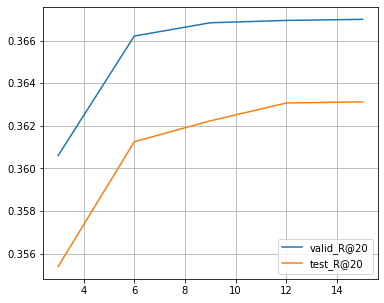

step 15:
|------------|--------|
| valid_RMSE | 0.6890 |
| valid_R@20 | 0.3670 |
| test_RMSE  | 0.6932 |
| test_R@20  | 0.3631 |

Training took 5.41s per sweep, 1.84s per eval


In [ ]:
baseline_20m = DPALSModel(
    ml20m, binarize=True, regularization_weight=40.0,
    unobserved_weight=0.2, embedding_dim=64, recall_positions=[20],
    row_reg_exponent=0, col_reg_exponent=0, init_stddev=0.1,
    sanitizer=Sanitizer(item_frac=0.1, exact_split=True),
    random_seed=1234, batch_size=10_000)
baseline_20m.train(num_steps=15, compute_metrics=True,
                   plot_metrics=RECALL_METRICS, num_eval_points=5)


In [ ]:
def train_20m(
    method, budget, max_norm, steps, reg, unobs, epsilon, count_stddev,
    weight_exp=0):
  delta = 8e-6
  sanitizer = Sanitizer(
      budget=budget, method=method, item_frac=0.1,
      center=False, count_stddev=count_stddev,
      count_sample=budget, weight_exponent=weight_exp, exact_split=True,
      random_seed=1234)
  optimizer = DPALSOptimizer(budget, max_norm)
  accountant = DPALSAccountant(sanitizer, optimizer, steps=steps)
  accountant.set_sigmas(epsilon, delta, sigma_ratio0=1, sigma_ratio1=1)
  model = DPALSModel(
      ml20m, binarize=True, embedding_dim=64, init_stddev=0.1,
      regularization_weight=reg, unobserved_weight=unobs,
      sanitizer=sanitizer, optimizer=optimizer, recall_positions=[20],
      random_seed=1234, batch_size=10_000)
  model.train(num_steps=steps, compute_metrics=False)
  return model

### $\epsilon = 1$

In [ ]:
def train_20m_eps1(method, max_norm, reg, unobs, weight_exp=0):
  return train_20m(
      method=method, max_norm=max_norm, reg=reg, unobs=unobs,
      weight_exp=weight_exp, budget=100, steps=3, count_stddev=200, epsilon=1)

model20m_eps1_tail = train_20m_eps1(method="tail", reg=40, unobs=0.4, max_norm=0.1)
model20m_eps1_unif = train_20m_eps1(method="uniform", reg=30, unobs=0.4, max_norm=0.1)
model20m_eps1_ada1 = train_20m_eps1(method="adaptive_weights", weight_exp=-1, reg=10, unobs=0.8, max_norm=0.05)
model20m_eps1_ada2 = train_20m_eps1(method="adaptive_weights", weight_exp=-1/2, reg=30, unobs=0.4, max_norm=0.05)
model20m_eps1_ada3 = train_20m_eps1(method="adaptive_weights", weight_exp=-1/3, reg=30, unobs=0.4, max_norm=0.05)
model20m_eps1_ada4 = train_20m_eps1(method="adaptive_weights", weight_exp=-1/4, reg=30, unobs=0.4, max_norm=0.05)
model20m_eps1_ada0 = train_20m_eps1(method="adaptive_weights", weight_exp=0, reg=50, unobs=0.4, max_norm=0.1)

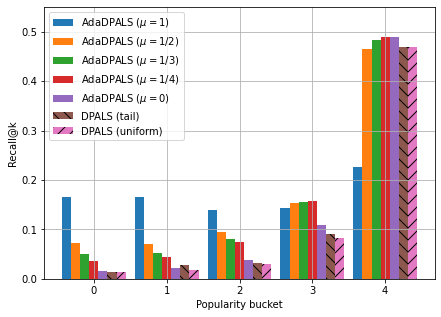

In [ ]:
bar_plot_recall([
    ("AdaDPALS ($\mu=1$)",   model20m_eps1_ada1, 0),
    ("AdaDPALS ($\mu=1/2$)", model20m_eps1_ada2, 1),
    ("AdaDPALS ($\mu=1/3$)", model20m_eps1_ada3, 2),
    ("AdaDPALS ($\mu=1/4$)", model20m_eps1_ada4, 3),
    ("AdaDPALS ($\mu=0$)",   model20m_eps1_ada0, 4),
    ("DPALS (tail)",         model20m_eps1_tail, 5),
    ("DPALS (uniform)",      model20m_eps1_unif, 6),
], num_buckets=5, scale_k=True)

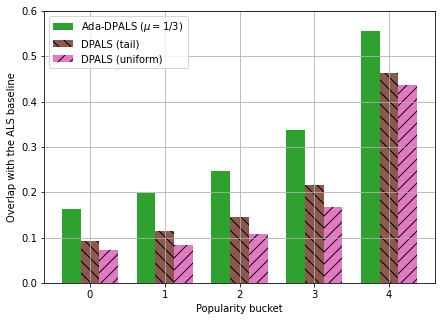

In [ ]:
bar_plot_overlap([
    ("Ada-DPALS ($\mu = 1/3$)", model20m_eps1_ada3, 2),
    ("DPALS (tail)", model20m_eps1_tail, 5),
    ("DPALS (uniform)", model20m_eps1_unif, 6),
], baseline_20m, ylim=[0, 0.6])

In [ ]:
# Nearest neighbors (used in the paper)
seed = "Shawshank Redemption" #@param ["Shawshank Redemption", "Pinocchio", "Nausica", "Harry Potter and the Half-Blood Prince", "Interstellar"]
latex = False #@param {"type": "boolean"}
models = {
    "ALS": baseline_20m,
    "DPALS (tail)": model20m_eps1_tail,
    "Ada-DPALS": model20m_eps1_ada3,
}

for label, model in models.items():
  print(f"======================================= {label} =======================================")
  v = Visualizer(model)
  x = v.nearest_neighbors(
      seed, cosine=True, k=7,
      latex=latex, latex_cols=["", "title", "genres", "num_ratings"])

### $\epsilon = 5$

In [ ]:
def train_20m_eps5(method, max_norm, reg, unobs, weight_exp=0):
  return train_20m(
      method=method, max_norm=max_norm, reg=reg, unobs=unobs,
      weight_exp=weight_exp, budget=100, steps=4, count_stddev=40, epsilon=5)

model20m_eps5_tail = train_20m_eps5(method="tail", reg=30, unobs=0.2, max_norm=0.1)
model20m_eps5_unif = train_20m_eps5(method="uniform", reg=40, unobs=0.4, max_norm=0.1)
model20m_eps5_ada1 = train_20m_eps5(method="adaptive_weights", weight_exp=-1, reg=10, unobs=0.4, max_norm=0.05)
model20m_eps5_ada2 = train_20m_eps5(method="adaptive_weights", weight_exp=-1/2, reg=30, unobs=0.3, max_norm=0.1)
model20m_eps5_ada3 = train_20m_eps5(method="adaptive_weights", weight_exp=-1/3, reg=40, unobs=0.3, max_norm=0.15)
model20m_eps5_ada4 = train_20m_eps5(method="adaptive_weights", weight_exp=-1/4, reg=40, unobs=0.3, max_norm=0.2)
model20m_eps5_ada0 = train_20m_eps5(method="adaptive_weights", weight_exp=0, reg=50, unobs=0.3, max_norm=0.2)

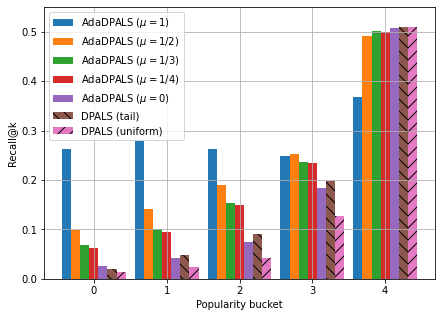

In [ ]:
bar_plot_recall([
    ("AdaDPALS ($\mu=1$)",   model20m_eps5_ada1, 0),
    ("AdaDPALS ($\mu=1/2$)", model20m_eps5_ada2, 1),
    ("AdaDPALS ($\mu=1/3$)", model20m_eps5_ada3, 2),
    ("AdaDPALS ($\mu=1/4$)", model20m_eps5_ada4, 3),
    ("AdaDPALS ($\mu=0$)",   model20m_eps5_ada0, 4),
    ("DPALS (tail)",         model20m_eps5_tail, 5),
    ("DPALS (uniform)",      model20m_eps5_unif, 6),
], num_buckets=5, scale_k=True)

### $\epsilon=20$

In [ ]:
def train_20m_eps20(method, max_norm, reg, unobs, weight_exp=0):
  return train_20m(
      method=method, max_norm=max_norm, reg=reg, unobs=unobs,
      weight_exp=weight_exp, budget=100, steps=5, count_stddev=10, epsilon=20)

model20m_eps20_tail = train_20m_eps20(method="tail", reg=30, unobs=0.2, max_norm=0.1)
model20m_eps20_unif = train_20m_eps20(method="uniform", reg=30, unobs=0.2, max_norm=0.1)
model20m_eps20_ada1 = train_20m_eps20(method="adaptive_weights", weight_exp=-1, reg=20, unobs=0.2, max_norm=0.2)
model20m_eps20_ada2 = train_20m_eps20(method="adaptive_weights", weight_exp=-1/2, reg=30, unobs=0.2, max_norm=0.2)
model20m_eps20_ada3 = train_20m_eps20(method="adaptive_weights", weight_exp=-1/3, reg=30, unobs=0.1, max_norm=0.2)
model20m_eps20_ada4 = train_20m_eps20(method="adaptive_weights", weight_exp=-1/4, reg=30, unobs=0.1, max_norm=0.2)
model20m_eps20_ada0 = train_20m_eps20(method="adaptive_weights", weight_exp=0, reg=30, unobs=0.1, max_norm=0.2)

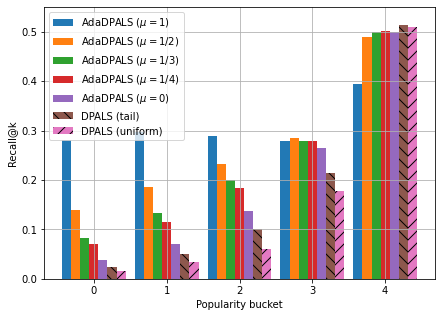

In [ ]:
bar_plot_recall([
    ("AdaDPALS ($\mu=1$)",   model20m_eps20_ada1, 0),
    ("AdaDPALS ($\mu=1/2$)", model20m_eps20_ada2, 1),
    ("AdaDPALS ($\mu=1/3$)", model20m_eps20_ada3, 2),
    ("AdaDPALS ($\mu=1/4$)", model20m_eps20_ada4, 3),
    ("AdaDPALS ($\mu=0$)",   model20m_eps20_ada0, 4),
    ("DPALS (tail)",         model20m_eps20_tail, 5),
    ("DPALS (uniform)",      model20m_eps20_unif, 6),
], num_buckets=5, scale_k=True)

## ML10M

### Non-private baseline

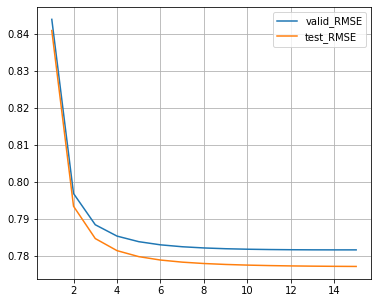

step 15:
|-----------------|--------|
| valid_RMSE      | 0.7816 |
| valid_RMSE_user | 0.7816 |
| test_RMSE       | 0.7772 |
| test_RMSE_user  | 0.7772 |

Training took 4.69s per sweep, 6.74s per eval


In [ ]:
# Basline (non-private) RMSE: 0.777 on test
wals_10m = DPALSModel(
    ml10m, binarize=False, embedding_dim=64, init_stddev=0.1,
    regularization_weight=80, row_reg_exponent=1, col_reg_exponent=1,
    unobserved_weight=0.0, batch_size=2000)
wals_10m.train(num_steps=15, plot_metrics=RMSE_METRICS, num_eval_points=15)

In [ ]:
def train_10m(
    method, max_norm, steps, reg, epsilon, count_stddev, budget=100,
    weight_exp=0, reg_exponent=0.25, dim=32):
  item_frac = 1
  delta = 1e-5
  sanitizer = Sanitizer(
      budget=budget, method=method, weight_exponent=weight_exp, center=True,
      item_frac=item_frac, count_stddev=count_stddev, count_sample=budget)
  optimizer = DPALSOptimizer(budget=budget, max_norm=max_norm)
  accountant = DPALSAccountant(sanitizer, optimizer, steps=steps)
  accountant.set_sigmas(
      target_epsilon=epsilon, target_delta=delta, sigma_ratio0=np.inf,
      sigma_ratio1=1)
  dpals_10m = DPALSModel(
      ml10m, binarize=False, embedding_dim=dim, init_stddev=0.1,
      regularization_weight=reg, row_reg_exponent=reg_exponent,
      col_reg_exponent=reg_exponent, unobserved_weight=0.0, sanitizer=sanitizer,
      optimizer=optimizer, batch_size=2000)
  dpals_10m.train(num_steps=steps, compute_metrics=False)
  return dpals_10m


### $\epsilon = 1$

In [ ]:
def train_10m_eps1(method, max_norm, reg, reg_exponent=0.25, weight_exp=0):
  return train_10m(
      method=method, max_norm=max_norm, reg=reg, reg_exponent=reg_exponent,
      weight_exp=weight_exp, dim=8, steps=2, count_stddev=200, epsilon=1)

model10m_eps1_tail = train_10m_eps1(reg=60, max_norm=0.2, method="tail")
model10m_eps1_unif = train_10m_eps1(reg=60, max_norm=0.2, method="uniform")
model10m_eps1_ada1 = train_10m_eps1(reg=30, max_norm=0.1, method="adaptive_weights", weight_exp=-1, reg_exponent=0)
model10m_eps1_ada2 = train_10m_eps1(reg=40, max_norm=0.2, method="adaptive_weights", weight_exp=-1/2)
model10m_eps1_ada3 = train_10m_eps1(reg=40, max_norm=0.2, method="adaptive_weights", weight_exp=-1/3)
model10m_eps1_ada4 = train_10m_eps1(reg=40, max_norm=0.2, method="adaptive_weights", weight_exp=-1/4)

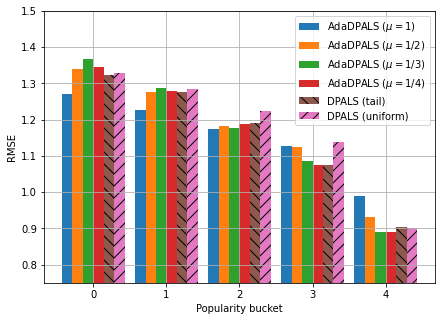

In [ ]:
bar_plot_rmse([
    ("AdaDPALS ($\mu=1$)",   model10m_eps1_ada1, 0),
    ("AdaDPALS ($\mu=1/2$)", model10m_eps1_ada2, 1),
    ("AdaDPALS ($\mu=1/3$)", model10m_eps1_ada3, 2),
    ("AdaDPALS ($\mu=1/4$)", model10m_eps1_ada4, 3),
    ("DPALS (tail)",         model10m_eps1_tail, 5),
    ("DPALS (uniform)",      model10m_eps1_unif, 6),
], item_frac = 1.0, num_buckets = 5, ylim=[0.75, 1.5])

### $\epsilon = 5$

In [ ]:
def train_10m_eps5(method, max_norm, reg, reg_exponent=0.25, weight_exp=0):
  return train_10m(
      method=method, max_norm=max_norm, reg=reg, reg_exponent=reg_exponent,
      weight_exp=weight_exp, dim=32, steps=3, count_stddev=40, epsilon=5)

model10m_eps5_tail = train_10m_eps5(reg=40, max_norm=0.5, method="tail")
model10m_eps5_unif = train_10m_eps5(reg=40, max_norm=0.5, method="uniform")
model10m_eps5_ada1 = train_10m_eps5(reg=40, max_norm=0.5, method="adaptive_weights", weight_exp=-1, reg_exponent=0)
model10m_eps5_ada2 = train_10m_eps5(reg=60, max_norm=0.5, method="adaptive_weights", weight_exp=-1/2)
model10m_eps5_ada3 = train_10m_eps5(reg=60, max_norm=0.5, method="adaptive_weights", weight_exp=-1/3)
model10m_eps5_ada4 = train_10m_eps5(reg=60, max_norm=0.5, method="adaptive_weights", weight_exp=-1/4)

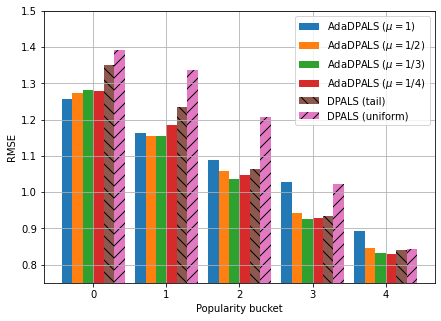

In [ ]:
bar_plot_rmse([
    ("AdaDPALS ($\mu=1$)",   model10m_eps5_ada1, 0),
    ("AdaDPALS ($\mu=1/2$)", model10m_eps5_ada2, 1),
    ("AdaDPALS ($\mu=1/3$)", model10m_eps5_ada3, 2),
    ("AdaDPALS ($\mu=1/4$)", model10m_eps5_ada4, 3),
    ("DPALS (tail)",         model10m_eps5_tail, 5),
    ("DPALS (uniform)",      model10m_eps5_unif, 6),
], item_frac = 1.0, num_buckets = 5, ylim=[0.75, 1.5])

### $\epsilon = 20$

In [ ]:
def train_10m_eps20(method, max_norm, reg, reg_exponent=0.25, weight_exp=0):
  return train_10m(
      method=method, max_norm=max_norm, reg=reg, reg_exponent=reg_exponent,
      weight_exp=weight_exp, dim=32, steps=4, count_stddev=10, epsilon=20)

model10m_eps20_tail = train_10m_eps20(reg=40, max_norm=0.5, method="tail")
model10m_eps20_unif = train_10m_eps20(reg=40, max_norm=0.5, method="uniform")
model10m_eps20_ada1 = train_10m_eps20(reg=10, max_norm=0.5, method="adaptive_weights", weight_exp=-1, reg_exponent=0)
model10m_eps20_ada2 = train_10m_eps20(reg=40, max_norm=0.5, method="adaptive_weights", weight_exp=-1/2)
model10m_eps20_ada3 = train_10m_eps20(reg=40, max_norm=0.5, method="adaptive_weights", weight_exp=-1/3)
model10m_eps20_ada4 = train_10m_eps20(reg=40, max_norm=0.5, method="adaptive_weights", weight_exp=-1/4)

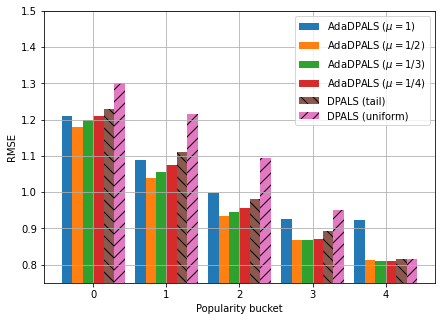

In [ ]:
bar_plot_rmse([
    ("AdaDPALS ($\mu=1$)",   model10m_eps20_ada1, 0),
    ("AdaDPALS ($\mu=1/2$)", model10m_eps20_ada2, 1),
    ("AdaDPALS ($\mu=1/3$)", model10m_eps20_ada3, 2),
    ("AdaDPALS ($\mu=1/4$)", model10m_eps20_ada4, 3),
    ("DPALS (tail)",         model10m_eps20_tail, 5),
    ("DPALS (uniform)",      model10m_eps20_unif, 6),
], item_frac = 1.0, num_buckets = 5, ylim=[0.75, 1.5])

# Example training with AM-DPSGD

Alternating minimization where:
- The user update is a Least Squares (exact) update.
- The item update is (DP)SGD. This is much faster on GPU.

In [ ]:
# Use a simple embedding layer as encoder.

class Encoder(tf.keras.Model):
  def __init__(
      self, vocab_size, embedding_dim, reg, unobserved_weight=0, stddev=0.01,
      gramian=None, item_counts=None):
    super().__init__()
    self.reg = reg
    if unobserved_weight:
      if gramian is None or item_counts is None:
        raise ValueError(
            "gramian and item_counts are required when unobserved_weight > 0")
    self.unobserved_weight = unobserved_weight
    self.gramian = gramian
    self.item_counts = item_counts
    self.embeddings = tf.keras.layers.Embedding(
        vocab_size, embedding_dim,
        embeddings_initializer=tf.keras.initializers.random_normal(
            stddev=stddev),
        activity_regularizer=None)

  def call(self, features):
    return self.embeddings(features["sid"])

  # @tf.function
  def loss_vector(self, predictions, labels, weights, features):
    """Implements quadratic loss with frequency regularization.
    
    Args:
      predictions: a [batch_size] vector of predictions.
      labels: a [batch_size] vector of labels.
      weights: a [batch_size] vector of weights. Useful for the adaptive_weights
        method.
      features: a dict of features, used to get the item ids.
    """
    col_emb = self.trainable_variables[0]
    col_norms = tf.reduce_sum(tf.square(col_emb), axis=1)/2
    loss_vector = (
        tf.pow(labels - predictions, 2)/2*weights
        + self.reg * tf.gather(col_norms, features["sid"])
        )
    if self.unobserved_weight:
      emb = self.embeddings(features["sid"])
      counts = tf.cast(tf.gather(self.item_counts, features["sid"]), tf.float32)
      # gravity = \sum_{i \in batch} v_i^T G v_i/2 / c_i
      # where v_i is the embedding, G is the Gramian, and c_i is the (noisy)
      # count for item i.
      gravity = tf.reduce_sum(tf.matmul(emb, self.gramian)*emb, axis=1)/counts
      loss_vector += self.unobserved_weight * gravity
    return loss_vector

### Non-private

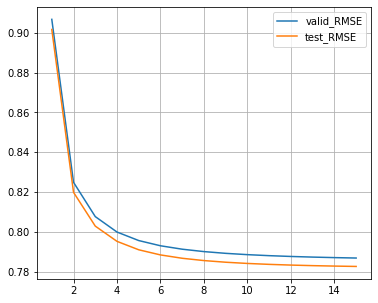

step 15:
|-----------------|--------|
| valid_RMSE      | 0.7869 |
| valid_RMSE_user | 0.7869 |
| test_RMSE       | 0.7827 |
| test_RMSE_user  | 0.7827 |

Training took 58.59s per sweep, 7.51s per eval


In [ ]:
dim = 64
am_10m = AMModel(
    ml10m, binarize=False, embedding_dim=dim, init_stddev=0.1,
    regularization_weight=15, unobserved_weight=0.0,
    row_reg_exponent=1)
am_10m.compile_item_tower(
    item_encoder=Encoder(ml10m.num_items, dim, reg=0.04, stddev=0.1),
    item_batch_size=100_000,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001))
am_10m.train(
    num_steps=15, inner_steps=4096, num_eval_points=15,
    plot_metrics=RMSE_METRICS, compute_metrics=True)

### Private, with adaptive weights.

In [ ]:
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras_sparse as dps

def train_10m_am(
    steps, inner_steps, learning_rate, clip_norm, count_stddev, epsilon,
    method="adaptive_weights", weight_exp=0, dim=32, acc_steps=139,
    num_users_per_batch=500, reg=0.5, item_frac=1.0, budget=100):
  """Trains a RMSE model on ML10M data."""
  # The logical batch is 139*500 = 69.5K, i.e. full batch (there are 69878 users)
  delta = 1e-5
  ds = ml10m
  num_examples_per_user = budget
  sanitizer = Sanitizer(
      center=True, budget=budget, method=method, weight_exponent=weight_exp,
      item_frac=item_frac, count_stddev=count_stddev, count_sample=budget)
  accountant = DPAMAccountant(
      sanitizer,
      steps=steps*inner_steps,
      num_users_per_batch=num_users_per_batch,
      gradient_accumulation_steps=acc_steps,
      num_users=ds.num_users)
  accountant.set_noise_multiplier(target_epsilon=epsilon, target_delta=delta)
  optimizer = dps.DPSparseKerasSGDOptimizer(
      l2_norm_clip=clip_norm,
      noise_multiplier=accountant.noise_multiplier,
      num_microbatches=num_users_per_batch,
      gradient_accumulation_steps=acc_steps,
      learning_rate=learning_rate*num_users_per_batch)
  model = AMModel(
      ds, binarize=False, embedding_dim=dim, init_stddev=0.1,
      regularization_weight=reg, unobserved_weight=0,
      sanitizer=sanitizer)
  model.compile_item_tower(
      item_encoder=Encoder(ds.num_items, dim, reg=reg),
      num_users_per_batch=num_users_per_batch,
      num_examples_per_user=num_examples_per_user,
      optimizer=optimizer) 
  model.train(
      num_steps=steps, inner_steps=inner_steps*acc_steps, num_eval_points=steps,
      compute_metrics=True, plot_metrics=RMSE_METRICS)
  return model

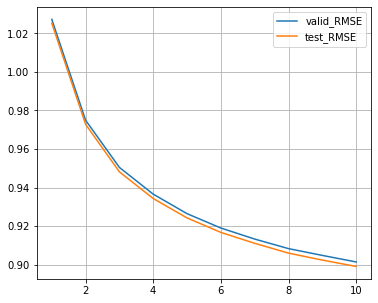

step 10:
|-----------------|--------|
| valid_RMSE      | 0.9014 |
| valid_RMSE_user | 0.9014 |
| test_RMSE       | 0.8991 |
| test_RMSE_user  | 0.8991 |

Training took 27.23s per sweep, 5.04s per eval


In [ ]:
am_10m_eps1 = train_10m_am(
    steps=10, inner_steps=4, learning_rate=0.5, clip_norm=0.1,
    method="adaptive_weights", weight_exp=-1/4, count_stddev=200, epsilon=1)